# Analyst–Firm Coverage Network

This notebook constructs a network representation of firm–analyst coverage.  
The pipeline includes data preparation, filtering, matrix construction, and graph embeddings.

---

## Data Organization

We begin by loading the dataset of firm–year–analyst coverage.  
Each row corresponds to a triplet (firm, year, analyst).  
The raw identifier `permno` is renamed to `firm` for clarity.


In [ ]:
import pandas as pd
df = pd.read_csv("202506_analys_firm_year_yonatan.csv")[["permno","year","analys"]].rename(columns={'permno': 'firm'})
df.head()


,firm,year,analys
0,10825.0,2010,1
1,10874.0,2010,1
2,17830.0,2010,1
3,17830.0,2011,1
4,38578.0,2010,1


## Initial Dataset Statistics

We compute initial statistics to understand the raw dataset:  
- Number of unique (firm, year) pairs  
- Number of unique analysts  

This step provides a baseline before data cleaning.


In [ ]:
num_firm_years = df[['firm', 'year']].drop_duplicates().shape[0]
print("Unique (firm, year) pairs:", num_firm_years)


num_analysts = df['analys'].nunique()
print("Unique analysts:", num_analysts)


Unique (firm, year) pairs: 133194
Unique analysts: 19195


In [ ]:
df = df.dropna()
df["firm"] = df["firm"].astype(int)          # optional: enforce int IDs
df["year"] = df["year"].astype(int)


In [ ]:
num_firm_years = df[['firm', 'year']].drop_duplicates().shape[0]
print("Unique (firm, year) pairs:", num_firm_years)


num_analysts = df['analys'].nunique()
print("Unique analysts:", num_analysts)


Unique (firm, year) pairs: 133152
Unique analysts: 19195


## Step 1: Analyst–Firm Coverage

We calculate how many unique firms each analyst covers in a given year.

### Step 1a: Count Firm Coverage per Analyst-Year
We group by (analyst, year) and count unique firms.

### Step 1b: Filter Analysts by Coverage
We restrict the dataset to analysts covering at least 30 firms in a given year.  
This ensures the network is based on analysts with sufficient breadth of coverage.

### Step 1c: Post-Filtering Statistics
We recompute the number of unique firm–year pairs and analysts to assess the effect of filtering.


In [ ]:
# Step 1: Count number of unique firms per analyst-year
coverage = df.groupby(['analys', 'year'])['firm'].nunique().reset_index(name='firm_count')

# Step 2: Keep analyst-year pairs with <= 30 firms
allowed = coverage[coverage['firm_count'] <= 30]

# Step 3: Merge with original df to keep only allowed analyst-year rows
df = df.merge(allowed[['analys', 'year']], on=['analys', 'year'], how='inner')


In [ ]:
num_firm_years = df[['firm', 'year']].drop_duplicates().shape[0]
print("Unique (firm, year) pairs:", num_firm_years)


num_analysts = df['analys'].nunique()
print("Unique analysts:", num_analysts)

Unique (firm, year) pairs: 130012
Unique analysts: 19170


## Step 2: Construct Analyst–Firm Matrix

We represent the dataset as a sparse bipartite matrix:
- Rows = firm–year nodes  
- Columns = analysts  
- Entries = 1 if the analyst covers the firm in that year  

This bipartite structure is efficient for storage and computation.


In [ ]:
# Firms and analysts count per year
firms_per_year = df.groupby("year")["firm"].nunique()
analysts_per_year = df.groupby("year")["analys"].nunique()

stats_yearly = pd.DataFrame({
    "n_firms": firms_per_year,
    "n_analysts": analysts_per_year
})
print(stats_yearly.head())


      n_firms  n_analysts
year                     
1983     1455        1530
1984     1579        1509
1985     1622        1474
1986     1632        1455
1987     1725        1423


In [ ]:
# Unique analysts covering each firm-year
analysts_per_firm_year = (
    df.groupby(["firm", "year"])["analys"]
      .nunique()
      .reset_index(name="n_analysts")
)

print(analysts_per_firm_year.head())
print(analysts_per_firm_year["n_analysts"].describe())


    firm  year  n_analysts
0  10001  1998           1
1  10001  1999           2
2  10001  2000           2
3  10001  2001           1
4  10001  2011           1
count    130012.000000
mean          8.400178
std           8.849183
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max          84.000000
Name: n_analysts, dtype: float64


In [ ]:
# Unique firms covered by each analyst-year
firms_per_analyst_year = (
    df.groupby(["analys", "year"])["firm"]
      .nunique()
      .reset_index(name="n_firms")
)

print(firms_per_analyst_year.head())
print(firms_per_analyst_year["n_firms"].describe())


   analys  year  n_firms
0       1  2010       22
1       1  2011       18
2       1  2012        4
3       3  1985        1
4       3  1986        1
count    130910.000000
mean          8.342556
std           7.294254
min           1.000000
25%           2.000000
50%           6.000000
75%          13.000000
max          30.000000
Name: n_firms, dtype: float64


## Step 3: Firm–Firm Co-Coverage Matrix

By multiplying the bipartite matrix with its transpose, we obtain a firm–firm similarity matrix:
- Entry M[i,j] = number of analysts covering both firm i and firm j in the same year.  

This matrix forms the basis of the firm similarity network.


In [ ]:
import numpy as np, pandas as pd
from scipy.sparse import coo_matrix

# ---------- 2.1  integer codes ----------
row_keys = pd.Categorical(df[['firm', 'year']].apply(tuple, axis=1))
col_keys = pd.Categorical(df['analys'])

row_idx = row_keys.codes.astype('int32')
col_idx = col_keys.codes.astype('int32')

n_rows = len(row_keys.categories)
n_cols = len(col_keys.categories)

# ---------- 2.2  build sparse matrix ----------
values  = np.ones_like(row_idx, dtype=np.uint8)          # 1 = coverage
A = coo_matrix((values, (row_idx, col_idx)),
               shape=(n_rows, n_cols), dtype=np.uint8).tocsr()


In [ ]:
A.sum() == len(df)


True

In [ ]:
row_nnz  = A.getnnz(axis=1)
row_norm = np.sqrt(row_nnz).astype(np.float32)


In [ ]:
M = (A @ A.T).tocoo()      # counts of shared analysts


In [ ]:
print("Unique values in A.data:", np.unique(A.data))
print("Unique values in M.data:", np.unique(M.data))


Unique values in A.data: [1]
Unique values in M.data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 76 78 84]


### Normalization of Co-Coverage

We normalize similarities to account for firm size effects.  
Each entry is divided by the product of the coverage norms of the two firms.  
This yields a cosine-style similarity between firms.


In [ ]:
import numba as nb

@nb.njit(parallel=True, fastmath=True)
def normalise(data, row, col, norm):
    for i in nb.prange(data.size):
        data[i] = data[i] / (norm[row[i]] * norm[col[i]])


M.data = M.data.astype(np.float32)
normalise(M.data, M.row, M.col, row_norm)


### Thresholding Firm Similarities

We apply a similarity threshold to filter edges:  
- Only firm pairs with similarity above the threshold are retained.  
- This reduces noise and yields a cleaner network.


In [ ]:
threshold = 0.0
keep = M.data >= threshold

src = M.row[keep]    # index of firm-year i
dst = M.col[keep]    # index of firm-year j
wgt = M.data[keep]   # similarity weight

not_self = src != dst
src = src[not_self]
dst = dst[not_self]
wgt = wgt[not_self]


In [ ]:
len(set(src) | set(dst))

129985

In [ ]:
all_indices = set(range(M.shape[0]))
connected_indices = set(src) | set(dst)
disconnected = all_indices - connected_indices

print("Disconnected firm-years:", len(disconnected))
row_sums = np.array(M.sum(axis=1)).flatten()

# Firm-years where row sum == 1
exact_ones = np.isclose(row_sums, 1.0)
print("Firm-years with row sum == 1:", np.sum(exact_ones))


Disconnected firm-years: 27
Firm-years with row sum == 1: 27


### Edge List Construction

We convert the firm–firm similarity matrix into an edge list.  
Each row records a firm–year pair, its neighbor, and the similarity weight.  
This format is required for embedding algorithms.


In [ ]:
# Convert back from index to labels
firm_years = row_keys.categories

edges = pd.DataFrame({
    'firm_year_i': [firm_years[i] for i in src],
    'firm_year_j': [firm_years[j] for j in dst],
    'similarity': wgt
})


In [ ]:
edges.head()

,firm_year_i,firm_year_j,similarity
0,"(10001, 1998)","(75298, 2001)",0.447214
1,"(10001, 1998)","(75298, 2000)",0.301511
2,"(10001, 1998)","(75298, 1999)",0.250000
3,"(10001, 1998)","(75298, 1998)",0.242536
4,"(10001, 1998)","(71395, 2002)",0.377964


In [ ]:
edges.head()
mask_bad = df["firm"].isna() | df["year"].isna()
print("rows with NaNs:", mask_bad.sum())
print(df.loc[mask_bad].head())


rows with NaNs: 0
Empty DataFrame
Columns: [firm, year, analys]
Index: []


In [ ]:
import os, time, random, warnings
import pandas as pd
import torch
print(torch.__version__)

2.2.2+cu121


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


CUDA Available: True
Device Count: 1
Device Name: NVIDIA RTX 6000 Ada Generation


## Node2Vec Embedding

We train Node2Vec to learn low-dimensional representations of firm–year nodes.

### Environment Setup
We verify GPU availability and set seeds for reproducibility.

### Node2Vec Configuration
We configure walk length, context size, number of walks per node, embedding dimension, and optimization settings.

### Training Procedure
We train embeddings using negative sampling.  
Loss is tracked for both training and validation sets.


In [ ]:
"""
Node2Vec with similarity-weighted sampling
------------------------------------------
• Each edge (i, j) is duplicated ⌊ similarity * K ⌋ times.
  – higher similarity → more duplicates → higher walk probability.
• No per-batch loss re-weighting is needed.
• Works on GPUs with CUDA 12.x and PyTorch ≥ 2.2.
"""

# -------------------------------------------------------------
# 0.  Imports and prerequisites
# -------------------------------------------------------------
import os, time, random, warnings, math
import numpy as np
import pandas as pd

import torch
from torch_geometric.nn import Node2Vec
from torch_sparse import SparseTensor
from tqdm import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------------------------------------------
# 1.  Configuration
# -------------------------------------------------------------
EMBED_DIM        = 128
WALK_LENGTH      = 80
CONTEXT_SIZE     = 20
WALKS_PER_NODE   = 10
NEGATIVE_SAMPLES = 5
LR               = 1e-2
BATCH_SIZE       = 64           # adjust if you hit OOM
MAX_EPOCHS       = 50
PATIENCE         = 3
DELTA            = 1e-4
DEVICE           = "cuda" if torch.cuda.is_available() else "cpu"
SEED             = 42

# similarity-to-duplicate scaling
K_DUPLICATES     = 15           # 1 ≤ K ≤ 20 is typical
MAX_REPEAT       = 20           # optional cap (heuristic)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------------------------------------------
# 2.  Build the base graph  (edges DataFrame must exist)
# -------------------------------------------------------------
all_nodes = pd.Index(
    pd.unique(pd.concat([edges["firm_year_i"], edges["firm_year_j"]], ignore_index=True))
)
node2id = pd.Series(np.arange(len(all_nodes), dtype=np.int64), index=all_nodes)

# (optional, for fast filtering later — build year columns once)
edges["year_i"] = edges["firm_year_i"].map(lambda t: t[1])
edges["year_j"] = edges["firm_year_j"].map(lambda t: t[1])

def create_graph(max_year):
    # Filter edges for this year cutoff
    mask = (
        edges["firm_year_i"].apply(lambda t: t[1]) <= max_year
    ) & (
        edges["firm_year_j"].apply(lambda t: t[1]) <= max_year
    )
    step_edges = edges.loc[mask].copy()

    # Factorize to get contiguous node IDs
    both = pd.concat([step_edges["firm_year_i"], step_edges["firm_year_j"]], ignore_index=True)
    codes, uniques = pd.factorize(both, sort=False)
    step_edges["src"] = codes[:len(step_edges)].astype("int64")
    step_edges["dst"] = codes[len(step_edges):].astype("int64")

    num_nodes = len(uniques)

    # Convert similarity to repeat factor
    sim    = step_edges["similarity"].clip(lower=0.0, upper=1.0).values
    repeat = np.clip(np.round(sim * K_DUPLICATES).astype(np.int64), 1, MAX_REPEAT)

    # Duplicate edges
    src_rep  = np.repeat(step_edges["src"].to_numpy(), repeat)
    dst_rep  = np.repeat(step_edges["dst"].to_numpy(), repeat)

    # Undirected edges: add reverse direction
    edge_src = np.concatenate([src_rep, dst_rep])
    edge_dst = np.concatenate([dst_rep, src_rep])

    edge_index = torch.as_tensor(
        np.vstack([edge_src, edge_dst]),
        dtype=torch.long,
        device=DEVICE,
    )

    print(f"[≤{max_year}] {num_nodes:,} nodes | {edge_index.size(1):,} edges")

    # Return graph + node mapping
    return edge_index, pd.Series(uniques)

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
def train_node2vec_for_year(max_year, edge_index, id2node):
    print(f"\n===== Training Node2Vec for years ≤ {max_year} =====")

    # Model
    model = Node2Vec(
        edge_index           = edge_index,
        embedding_dim        = EMBED_DIM,
        walk_length          = WALK_LENGTH,
        context_size         = CONTEXT_SIZE,
        walks_per_node       = WALKS_PER_NODE,
        num_negative_samples = NEGATIVE_SAMPLES,
        p = 1.0, q = 1.0,
        sparse = True
    ).to(DEVICE)

    # Data loaders
    train_loader = model.loader(
        batch_size          = BATCH_SIZE,
        shuffle             = True,
        num_workers         = 8,
        persistent_workers  = True,
        pin_memory          = True
    )
    val_loader = model.loader(
        batch_size          = BATCH_SIZE * 2,
        shuffle             = False,
        num_workers         = 2,
        persistent_workers  = True,
        pin_memory          = True
    )

    # Optimiser & scheduler
    opt   = torch.optim.SparseAdam(model.parameters(), lr=LR)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=1)

    # Training loop
    best_val, idle_epochs = None, 0
    t0 = time.time()
    ckpt_path = f"_best_node2vec_{max_year}.pt"

    for epoch in range(1, MAX_EPOCHS + 1):
        # Train
        model.train()
        total_loss = 0.0
        bar = tqdm(train_loader, desc=f"≤{max_year} Ep {epoch:02d} [train]", leave=False)
        for pos_rw, neg_rw in bar:
            pos_rw, neg_rw = pos_rw.to(DEVICE), neg_rw.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            loss = model.loss(pos_rw, neg_rw)
            loss.backward()
            opt.step()
            total_loss += loss.item()
            bar.set_postfix(loss=f"{loss.item():.4f}")
        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            bar = tqdm(val_loader, desc=f"≤{max_year} Ep {epoch:02d} [val]", leave=False)
            for pos_rw, neg_rw in bar:
                pos_rw, neg_rw = pos_rw.to(DEVICE), neg_rw.to(DEVICE)
                curr_val_loss = model.loss(pos_rw, neg_rw).item()
                val_loss += curr_val_loss
                bar.set_postfix(loss=f"{curr_val_loss:.4f}")
        val_loss /= len(val_loader)

        sched.step(val_loss)
        lr_now = opt.param_groups[0]["lr"]
        print(f"≤{max_year} │ epoch {epoch:02d} │ train {train_loss:.4f} │ val {val_loss:.4f} │ lr {lr_now:.2e}")

        # Early stopping
        if best_val is None or (best_val - val_loss) / (best_val + 1e-9) > DELTA:
            best_val, idle_epochs = val_loss, 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            idle_epochs += 1
            if idle_epochs >= PATIENCE:
                print(f"Early stop (≤{max_year})")
                break

    print(f"Training (≤{max_year}) done in {(time.time() - t0)/60:.1f} min │ best val = {best_val:.4f}")

    # Save embeddings
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    emb = model.embedding.weight.detach().cpu().numpy()
    emb_df = (
        pd.DataFrame(emb, columns=[f"dim_{d}" for d in range(EMBED_DIM)])
          .assign(firm_year=id2node.values)
          .set_index("firm_year")
    )
    out_path = f"firm_year_node2vec_embeddings_upto_{max_year}.parquet"
    emb_df.to_parquet(out_path, compression="zstd")
    print(f"Saved {len(emb_df):,} embeddings → {out_path}")

years_sorted = sorted(df["year"].unique())

for max_year in years_sorted:
    out_path = f"firm_year_node2vec_embeddings_upto_{max_year}.parquet"
    if os.path.exists(out_path):
        print(f"Skipping year ≤{max_year} — file already exists: {out_path}")
        continue
    edge_index, id2node = create_graph(max_year)
    train_node2vec_for_year(max_year, edge_index, id2node)

Skipping year ≤1983 — file already exists: firm_year_node2vec_embeddings_upto_1983.parquet
Skipping year ≤1984 — file already exists: firm_year_node2vec_embeddings_upto_1984.parquet
Skipping year ≤1985 — file already exists: firm_year_node2vec_embeddings_upto_1985.parquet
Skipping year ≤1986 — file already exists: firm_year_node2vec_embeddings_upto_1986.parquet
Skipping year ≤1987 — file already exists: firm_year_node2vec_embeddings_upto_1987.parquet
Skipping year ≤1988 — file already exists: firm_year_node2vec_embeddings_upto_1988.parquet
Skipping year ≤1989 — file already exists: firm_year_node2vec_embeddings_upto_1989.parquet
Skipping year ≤1990 — file already exists: firm_year_node2vec_embeddings_upto_1990.parquet
Skipping year ≤1991 — file already exists: firm_year_node2vec_embeddings_upto_1991.parquet
Skipping year ≤1992 — file already exists: firm_year_node2vec_embeddings_upto_1992.parquet
Skipping year ≤1993 — file already exists: firm_year_node2vec_embeddings_upto_1993.parquet

≤2024 │ epoch 01 │ train 1.7461 │ val 1.1506 │ lr 1.00e-02


≤2024 │ epoch 02 │ train 1.1493 │ val 1.1477 │ lr 1.00e-02


≤2024 │ epoch 03 │ train 1.1464 │ val 1.1454 │ lr 1.00e-02


≤2024 │ epoch 04 │ train 1.1451 │ val 1.1445 │ lr 1.00e-02


≤2024 │ epoch 05 │ train 1.1442 │ val 1.1442 │ lr 1.00e-02


≤2024 │ epoch 06 │ train 1.1440 │ val 1.1437 │ lr 1.00e-02


≤2024 │ epoch 07 │ train 1.1440 │ val 1.1437 │ lr 1.00e-02


≤2024 │ epoch 08 │ train 1.1439 │ val 1.1434 │ lr 1.00e-02


≤2024 │ epoch 09 │ train 1.1436 │ val 1.1435 │ lr 1.00e-02


≤2024 │ epoch 10 │ train 1.1434 │ val 1.1435 │ lr 5.00e-03


≤2024 │ epoch 11 │ train 1.1362 │ val 1.1352 │ lr 5.00e-03


≤2024 │ epoch 12 │ train 1.1352 │ val 1.1351 │ lr 5.00e-03


≤2024 │ epoch 13 │ train 1.1352 │ val 1.1351 │ lr 5.00e-03


≤2024 │ epoch 14 │ train 1.1352 │ val 1.1350 │ lr 2.50e-03


≤2024 │ epoch 15 │ train 1.1320 │ val 1.1310 │ lr 2.50e-03


≤2024 │ epoch 16 │ train 1.1309 │ val 1.1306 │ lr 2.50e-03


≤2024 │ epoch 17 │ train 1.1309 │ val 1.1307 │ lr 2.50e-03


≤2024 │ epoch 18 │ train 1.1307 │ val 1.1305 │ lr 1.25e-03


≤2024 │ epoch 19 │ train 1.1294 │ val 1.1288 │ lr 1.25e-03


≤2024 │ epoch 20 │ train 1.1287 │ val 1.1284 │ lr 1.25e-03


≤2024 │ epoch 21 │ train 1.1284 │ val 1.1284 │ lr 1.25e-03


≤2024 │ epoch 22 │ train 1.1284 │ val 1.1284 │ lr 6.25e-04


≤2024 │ epoch 23 │ train 1.1279 │ val 1.1277 │ lr 6.25e-04


≤2024 │ epoch 24 │ train 1.1276 │ val 1.1275 │ lr 6.25e-04


≤2024 │ epoch 25 │ train 1.1273 │ val 1.1273 │ lr 6.25e-04


≤2024 │ epoch 26 │ train 1.1274 │ val 1.1273 │ lr 6.25e-04


≤2024 │ epoch 27 │ train 1.1271 │ val 1.1272 │ lr 6.25e-04


≤2024 │ epoch 28 │ train 1.1272 │ val 1.1272 │ lr 6.25e-04


≤2024 │ epoch 29 │ train 1.1270 │ val 1.1271 │ lr 3.13e-04


≤2024 │ epoch 30 │ train 1.1271 │ val 1.1269 │ lr 3.13e-04


≤2024 │ epoch 31 │ train 1.1270 │ val 1.1267 │ lr 3.13e-04


≤2024 │ epoch 32 │ train 1.1268 │ val 1.1267 │ lr 3.13e-04


≤2024 │ epoch 33 │ train 1.1267 │ val 1.1266 │ lr 1.56e-04


≤2024 │ epoch 34 │ train 1.1266 │ val 1.1267 │ lr 1.56e-04
Early stop (≤2024)
Training (≤2024) done in 72.6 min │ best val = 1.1267
Saved 129,985 embeddings → firm_year_node2vec_embeddings_upto_2024.parquet


In [ ]:
import pandas as pd
years = range(1983,2024 +1)
file_path = "./firms_embedd/firm_year_node2vec_embeddings_upto_{}.parquet"
firms_dfs = {}
for year in years:
    print(f"proces {year=}")
    emb_df = pd.read_parquet(file_path.format(year))
    # Reset the index to make the tuple (firm, year) a column
    emb_df_reset = emb_df.reset_index()

    # Split the tuple in the first column into two separate columns: firm and year
    emb_df_reset[['firm', 'year']] = pd.DataFrame(emb_df_reset.iloc[:, 0].tolist(), index=emb_df_reset.index)

    # Drop the original column containing the tuple
    emb_df_reset = emb_df_reset.drop(columns=emb_df_reset.columns[0])

    # Set 'firm' and 'year' as MultiIndex again
    emb_df = emb_df_reset.set_index(['firm', 'year'])
    firms_dfs[year] = emb_df


proces year=1983
proces year=1984
proces year=1985
proces year=1986
proces year=1987
proces year=1988
proces year=1989
proces year=1990
proces year=1991
proces year=1992
proces year=1993
proces year=1994
proces year=1995
proces year=1996
proces year=1997
proces year=1998
proces year=1999
proces year=2000
proces year=2001
proces year=2002
proces year=2003
proces year=2004
proces year=2005
proces year=2006
proces year=2007
proces year=2008
proces year=2009
proces year=2010
proces year=2011
proces year=2012
proces year=2013
proces year=2014
proces year=2015
proces year=2016
proces year=2017
proces year=2018
proces year=2019
proces year=2020
proces year=2021
proces year=2022
proces year=2023
proces year=2024


# Incremental Clustering of Firm Embeddings

We extend the analysis by applying clustering across multiple years.  
The goal is to maintain consistent cluster assignments over time while incorporating new firm embeddings.


## Method: Incremental KNN with New Embeddings

We implement an incremental clustering approach:

1. **Initialization**  
   - For the first year, cluster firms into *k* groups using KMeans.  
   - These clusters serve as anchor groups for subsequent years.

2. **Incremental Assignment**  
   - For each new year, firms with previously assigned clusters retain their labels.  
   - New firms are classified into existing clusters using a K-Nearest Neighbor (KNN) classifier.  
   - This ensures stability in cluster numbering across years.

3. **Hard Memory**  
   - Once a firm is assigned to a cluster, it keeps that cluster label in future years.  
   - This “hard” assignment prevents clusters from drifting.

This method balances stability (consistent clusters) with adaptability (new firms).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

def incremental_knn_hard_with_new_embeddings(dict_up_to_year, n_clusters=50):
    """
    dict_up_to_year: dict[year -> DataFrame]
        Each DataFrame has index (firm, year) and embedding columns.
    n_clusters: int
        Number of clusters for initial year (KMeans).
    """
    cluster_results = {}
    years_sorted = sorted(dict_up_to_year.keys())
    first_year = years_sorted[0]

    # ---- Step 1: initial clustering on the first year ----
    df_first = dict_up_to_year[first_year]
    X_first = df_first.values
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels_first = km.fit_predict(X_first)

    cluster_results[first_year] = pd.DataFrame({
        "firm": [i[0] for i in df_first.index],
        "year": [i[1] for i in df_first.index],
        "cluster": labels_first
    }).set_index(["firm", "year"])

    print(f"[{first_year}] Initial clustering done with {n_clusters} clusters, "
          f"{len(labels_first)} firms assigned.")

    # Hard label memory: firm -> cluster (fixed once assigned)
    label_memory = {ix: lbl for ix, lbl in zip(df_first.index, labels_first)}

    # ---- Step 2: later years ----
    for year in years_sorted[1:]:
        df_curr = dict_up_to_year[year]
        X_curr = df_curr.values
        idx_curr = df_curr.index

        # anchors = all firms that already have labels, but use NEW embeddings
        anchors_idx = [ix for ix in idx_curr if ix in label_memory]
        anchors_X = np.array([X_curr[i] for i, ix in enumerate(idx_curr) if ix in label_memory])
        anchors_y = np.array([label_memory[ix] for ix in anchors_idx])

        # new firms-years to classify
        new_idx = [ix for ix in idx_curr if ix not in label_memory]
        new_X = np.array([X_curr[i] for i, ix in enumerate(idx_curr) if ix not in label_memory])

        labels_new = []
        if len(new_X) > 0:
            # dynamic k = sqrt(#anchors), enforce odd
            N = len(anchors_y)
            k = max(1, int(np.sqrt(N)))
            if (k & 1) == 0:
                k += 1

            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(anchors_X, anchors_y)
            labels_new = knn.predict(new_X)

            # update memory with new fixed labels
            for ix, lbl in zip(new_idx, labels_new):
                label_memory[ix] = lbl

        # build df for current year: old labels + new predicted labels
        labels_curr = [label_memory[ix] for ix in idx_curr]

        cluster_results[year] = pd.DataFrame({
            "firm": [i[0] for i in idx_curr],
            "year": [i[1] for i in idx_curr],
            "cluster": labels_curr
        }).set_index(["firm", "year"])

        print(f"[{year}] {len(new_idx)} new firms classified with k={k}, "
              f"anchors pool size {len(label_memory)}.")

    return cluster_results

cluster_results = incremental_knn_hard_with_new_embeddings(firms_dfs)

[1983] Initial clustering done with 50 clusters, 1424 firms assigned.
[1984] 1583 new firms classified with k=37, anchors pool size 3007.
[1985] 1626 new firms classified with k=55, anchors pool size 4633.
[1986] 1622 new firms classified with k=69, anchors pool size 6255.
[1987] 1725 new firms classified with k=79, anchors pool size 7980.
[1988] 1722 new firms classified with k=89, anchors pool size 9702.
[1989] 1609 new firms classified with k=99, anchors pool size 11311.
[1990] 1672 new firms classified with k=107, anchors pool size 12983.
[1991] 1719 new firms classified with k=113, anchors pool size 14702.
[1992] 1761 new firms classified with k=121, anchors pool size 16463.
[1993] 2102 new firms classified with k=129, anchors pool size 18565.
[1994] 2515 new firms classified with k=137, anchors pool size 21080.
[1995] 2864 new firms classified with k=145, anchors pool size 23944.
[1996] 3249 new firms classified with k=155, anchors pool size 27193.
[1997] 3634 new firms classifie

In [ ]:
def incremental_knn_hard_with_new_embeddings(
    dict_up_to_year,
    n_clusters=50,
    k_mode="dynamic",   # "dynamic" or int
):
    """
    dict_up_to_year: dict[year -> DataFrame]
    n_clusters: number of clusters in first year (KMeans)
    k_mode: "dynamic" (sqrt anchors) or int for fixed k
    """
    cluster_results = {}
    years_sorted = sorted(dict_up_to_year.keys())
    first_year = years_sorted[0]

    # ---- Step 1: initial clustering ----
    df_first = dict_up_to_year[first_year]
    X_first = df_first.values
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels_first = km.fit_predict(X_first)

    cluster_results[first_year] = pd.DataFrame({
        "firm": [i[0] for i in df_first.index],
        "year": [i[1] for i in df_first.index],
        "cluster": labels_first
    }).set_index(["firm", "year"])

    print(f"[{first_year}] Initial clustering done with {n_clusters} clusters.")

    # memory of hard labels
    label_memory = {ix: lbl for ix, lbl in zip(df_first.index, labels_first)}

    # ---- Step 2: later years ----
    for year in years_sorted[1:]:
        df_curr = dict_up_to_year[year]
        X_curr = df_curr.values
        idx_curr = df_curr.index

        # anchors
        anchors_idx = [ix for ix in idx_curr if ix in label_memory]
        anchors_X = np.array([X_curr[i] for i, ix in enumerate(idx_curr) if ix in label_memory])
        anchors_y = np.array([label_memory[ix] for ix in anchors_idx])

        # new
        new_idx = [ix for ix in idx_curr if ix not in label_memory]
        new_X = np.array([X_curr[i] for i, ix in enumerate(idx_curr) if ix not in label_memory])

        labels_new = []
        if len(new_X) > 0:
            if isinstance(k_mode, int):
                k = k_mode
            else:  # dynamic
                N = len(anchors_y)
                k = max(1, int(np.sqrt(N)))
                if (k & 1) == 0:
                    k += 1

            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(anchors_X, anchors_y)
            labels_new = knn.predict(new_X)

            for ix, lbl in zip(new_idx, labels_new):
                label_memory[ix] = lbl

        labels_curr = [label_memory[ix] for ix in idx_curr]

        cluster_results[year] = pd.DataFrame({
            "firm": [i[0] for i in idx_curr],
            "year": [i[1] for i in idx_curr],
            "cluster": labels_curr
        }).set_index(["firm", "year"])

        print(f"[{year}] {len(new_idx)} new firms classified, k={k}.")

    return cluster_results
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def validate_clusters(dict_up_to_year, cluster_results, year):
    df = dict_up_to_year[year]
    X = df.values
    labels = cluster_results[year]["cluster"].values

    sil = silhouette_score(X, labels, sample_size=2000)
    db  = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)

    print(f"Validation for {year}:")
    print(f"  Silhouette Score     = {sil:.4f}")
    print(f"  Davies-Bouldin Score = {db:.4f}")
    print(f"  Calinski-Harabasz    = {ch:.4f}")
    return {"silhouette": sil, "db": db, "ch": ch}

# # Example run:
# cluster_results = incremental_knn_hard_with_new_embeddings(
#     firms_dfs,
#     n_clusters=50,
#     k_mode=7  # or "dynamic"
# )

# validate_clusters(firms_dfs, cluster_results, 2024)
for k in [5, 13, "dynamic"]:
    for n_clusters in range(45, 55):
        cluster_results = incremental_knn_hard_with_new_embeddings(
            firms_dfs, n_clusters=n_clusters, k_mode=k
        )
        scores = validate_clusters(firms_dfs, cluster_results, 2024)
        print(f"k={k}, n_clusters={n_clusters} -> {scores}")


[1983] Initial clustering done with 45 clusters.
[1984] 1583 new firms classified, k=5.
[1985] 1626 new firms classified, k=5.
[1986] 1622 new firms classified, k=5.
[1987] 1725 new firms classified, k=5.
[1988] 1722 new firms classified, k=5.
[1989] 1609 new firms classified, k=5.
[1990] 1672 new firms classified, k=5.
[1991] 1719 new firms classified, k=5.
[1992] 1761 new firms classified, k=5.
[1993] 2102 new firms classified, k=5.
[1994] 2515 new firms classified, k=5.
[1995] 2864 new firms classified, k=5.
[1996] 3249 new firms classified, k=5.
[1997] 3634 new firms classified, k=5.
[1998] 5116 new firms classified, k=5.
[1999] 5235 new firms classified, k=5.
[2000] 4968 new firms classified, k=5.
[2001] 4326 new firms classified, k=5.
[2002] 3853 new firms classified, k=5.
[2003] 3619 new firms classified, k=5.
[2004] 3623 new firms classified, k=5.
[2005] 3722 new firms classified, k=5.
[2006] 3759 new firms classified, k=5.
[2007] 3779 new firms classified, k=5.
[2008] 3577 new

In [ ]:
cluster_results = incremental_knn_hard_with_new_embeddings(
            firms_dfs, n_clusters=52, k_mode="dynamic"
        )

[1983] Initial clustering done with 52 clusters.
[1984] 1583 new firms classified, k=37.
[1985] 1626 new firms classified, k=55.
[1986] 1622 new firms classified, k=69.
[1987] 1725 new firms classified, k=79.
[1988] 1722 new firms classified, k=89.
[1989] 1609 new firms classified, k=99.
[1990] 1672 new firms classified, k=107.
[1991] 1719 new firms classified, k=113.
[1992] 1761 new firms classified, k=121.
[1993] 2102 new firms classified, k=129.
[1994] 2515 new firms classified, k=137.
[1995] 2864 new firms classified, k=145.
[1996] 3249 new firms classified, k=155.
[1997] 3634 new firms classified, k=165.
[1998] 5116 new firms classified, k=175.
[1999] 5235 new firms classified, k=189.
[2000] 4968 new firms classified, k=203.
[2001] 4326 new firms classified, k=215.
[2002] 3853 new firms classified, k=225.
[2003] 3619 new firms classified, k=233.
[2004] 3623 new firms classified, k=241.
[2005] 3722 new firms classified, k=249.
[2006] 3759 new firms classified, k=255.
[2007] 3779 ne

In [ ]:
# cluster_results[2024]
# cluster_results[2024].reset_index().to_csv("clusters_all.csv", index=False)
cluster = cluster_results[2024]
cluster.head()

cluster
firm  year         
10001 1998       31
      1999       31
      2000       31
      2001       10
      2011       28

In [ ]:
firms_dfs[2024]

dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
firm  year                                                               
10001 1998 -0.061193  0.083222  0.063395 -0.085729  0.009294 -0.003045   
      1999 -0.085064  0.107519  0.034582 -0.172107  0.015057  0.021539   
      2000 -0.076188  0.084260  0.047002 -0.150082 -0.010305 -0.050754   
      2001  0.006510  0.118707  0.049292 -0.120302  0.077578 -0.025494   
      2011 -0.292418 -0.051666 -0.294662 -0.156245  0.119776  0.300962   
...              ...       ...       ...       ...       ...       ...   
93436 2020 -0.082020 -0.020241 -0.054193  0.093282  0.062031  0.053139   
      2021 -0.016055 -0.051973 -0.040551 -0.012168  0.125021  0.004521   
      2022 -0.058948 -0.010664 -0.080131 -0.039969  0.045446 -0.004689   
      2023 -0.005418 -0.064205 -0.049860 -0.025904  0.092396 -0.072806   
      2024 -0.041658  0.014187 -0.050743 -0.012197  0.097571  0.015213   

               dim_6     dim_7     dim_8     dim_9  ...   dim_118   dim_119  \
firm  year                                          ...                       
10001 1998  0.150582 -0.088432 -0.069518 -0.020817  ...  0.029216  0.014378   
      1999  0.137517 -0.084308 -0.049668  0.003143  ...  0.003422  0.018259   
      2000  0.144660 -0.003514  0.012281  0.045071  ...  0.005403  0.030579   
      2001  0.243246  0.003086  0.013855  0.009161  ...  0.037838  0.082382   
      2011 -0.434494  0.104611 -0.089741 -0.334155  ...  0.204560 -0.266400   
...              ...       ...       ...       ...  ...       ...       ...   
93436 2020 -0.690301 -0.175367  0.047025 -0.014329  ... -0.159490 -0.112417   
      2021 -0.705112 -0.250415  0.024206 -0.016397  ... -0.216202 -0.126514   
      2022 -0.745639 -0.192295  0.082901 -0.054975  ... -0.225571 -0.108850   
      2023 -0.730247 -0.176147  0.053815 -0.063668  ... -0.186431 -0.164445   
      2024 -0.798843 -0.163195 -0.013918 -0.132530  ... -0.090286 -0.048702   

             dim_120   dim_121   dim_122   dim_123   dim_124   dim_125  \
firm  year                                                               
10001 1998 -0.215758  0.040820  0.043682 -0.055192 -0.446376 -0.031276   
      1999 -0.162206  0.060444  0.020950 -0.007104 -0.496057 -0.011177   
      2000 -0.150629  0.067223  0.005327 -0.063782 -0.482039  0.030798   
      2001 -0.138064  0.066496 -0.005431 -0.018877 -0.579839  0.113201   
      2011  0.232448  0.044076 -0.367723 -0.219546 -0.307685 -0.218149   
...              ...       ...       ...       ...       ...       ...   
93436 2020  0.252663 -0.197464  0.021498 -0.037472 -0.022013  0.001817   
      2021  0.136907 -0.167579  0.122158  0.040146  0.118510 -0.037296   
      2022  0.115819 -0.162222  0.031588 -0.005202  0.065078 -0.043962   
      2023  0.169815 -0.180426  0.026747 -0.031835  0.067040 -0.048903   
      2024  0.040230 -0.122055  0.025805 -0.044172  0.232922  0.026060   

             dim_126   dim_127  
firm  year                      
10001 1998 -0.062823  0.124131  
      1999 -0.021370  0.051917  
      2000 -0.033348  0.102951  
      2001 -0.029698  0.073289  
      2011 -0.026260 -0.100911  
...              ...       ...  
93436 2020  0.032195 -0.002083  
      2021 -0.002253 -0.030474  
      2022  0.033385 -0.027907  
      2023  0.044207 -0.143690  
      2024  0.034742  0.014382  

[129985 rows x 128 columns]

# Embedding–Cluster Integration

We merge the learned embeddings with the clustering results.  
Each firm–year now has both:  
- A low-dimensional vector representation (Node2Vec embedding).  
- A discrete cluster label from incremental clustering.

This integrated dataset forms the basis for visual and statistical analysis.


## Visualization of Clusters

To better understand the structure of the embeddings, we apply dimensionality reduction.

### Step 1: Subsampling
If the dataset is too large, we randomly sample firm–years to make visualization feasible.

### Step 2: Dimensionality Reduction
We use t-SNE to project high-dimensional embeddings (128D) into two dimensions.  
This method preserves local structure, allowing us to observe cluster separation.

### Step 3: Plotting
Each point represents a firm–year, and colors correspond to cluster assignments.  
This visualization provides an intuitive view of whether clusters capture meaningful structure.


In [ ]:
emd_cluster = cluster.merge(
    firms_dfs[2024].reset_index(),
    left_on=["firm", "year"],
    right_on=["firm", "year"],
    how="inner"
).set_index(["firm", "year"])
emd_cluster

cluster     dim_0     dim_1     dim_2     dim_3     dim_4  \
firm  year                                                              
10001 1998       31 -0.061193  0.083222  0.063395 -0.085729  0.009294   
      1999       31 -0.085064  0.107519  0.034582 -0.172107  0.015057   
      2000       31 -0.076188  0.084260  0.047002 -0.150082 -0.010305   
      2001       10  0.006510  0.118707  0.049292 -0.120302  0.077578   
      2011       28 -0.292418 -0.051666 -0.294662 -0.156245  0.119776   
...             ...       ...       ...       ...       ...       ...   
93436 2020       24 -0.082020 -0.020241 -0.054193  0.093282  0.062031   
      2021       24 -0.016055 -0.051973 -0.040551 -0.012168  0.125021   
      2022       24 -0.058948 -0.010664 -0.080131 -0.039969  0.045446   
      2023       24 -0.005418 -0.064205 -0.049860 -0.025904  0.092396   
      2024       24 -0.041658  0.014187 -0.050743 -0.012197  0.097571   

               dim_5     dim_6     dim_7     dim_8  ...   dim_118   dim_119  \
firm  year                                          ...                       
10001 1998 -0.003045  0.150582 -0.088432 -0.069518  ...  0.029216  0.014378   
      1999  0.021539  0.137517 -0.084308 -0.049668  ...  0.003422  0.018259   
      2000 -0.050754  0.144660 -0.003514  0.012281  ...  0.005403  0.030579   
      2001 -0.025494  0.243246  0.003086  0.013855  ...  0.037838  0.082382   
      2011  0.300962 -0.434494  0.104611 -0.089741  ...  0.204560 -0.266400   
...              ...       ...       ...       ...  ...       ...       ...   
93436 2020  0.053139 -0.690301 -0.175367  0.047025  ... -0.159490 -0.112417   
      2021  0.004521 -0.705112 -0.250415  0.024206  ... -0.216202 -0.126514   
      2022 -0.004689 -0.745639 -0.192295  0.082901  ... -0.225571 -0.108850   
      2023 -0.072806 -0.730247 -0.176147  0.053815  ... -0.186431 -0.164445   
      2024  0.015213 -0.798843 -0.163195 -0.013918  ... -0.090286 -0.048702   

             dim_120   dim_121   dim_122   dim_123   dim_124   dim_125  \
firm  year                                                               
10001 1998 -0.215758  0.040820  0.043682 -0.055192 -0.446376 -0.031276   
      1999 -0.162206  0.060444  0.020950 -0.007104 -0.496057 -0.011177   
      2000 -0.150629  0.067223  0.005327 -0.063782 -0.482039  0.030798   
      2001 -0.138064  0.066496 -0.005431 -0.018877 -0.579839  0.113201   
      2011  0.232448  0.044076 -0.367723 -0.219546 -0.307685 -0.218149   
...              ...       ...       ...       ...       ...       ...   
93436 2020  0.252663 -0.197464  0.021498 -0.037472 -0.022013  0.001817   
      2021  0.136907 -0.167579  0.122158  0.040146  0.118510 -0.037296   
      2022  0.115819 -0.162222  0.031588 -0.005202  0.065078 -0.043962   
      2023  0.169815 -0.180426  0.026747 -0.031835  0.067040 -0.048903   
      2024  0.040230 -0.122055  0.025805 -0.044172  0.232922  0.026060   

             dim_126   dim_127  
firm  year                      
10001 1998 -0.062823  0.124131  
      1999 -0.021370  0.051917  
      2000 -0.033348  0.102951  
      2001 -0.029698  0.073289  
      2011 -0.026260 -0.100911  
...              ...       ...  
93436 2020  0.032195 -0.002083  
      2021 -0.002253 -0.030474  
      2022  0.033385 -0.027907  
      2023  0.044207 -0.143690  
      2024  0.034742  0.014382  

[129985 rows x 129 columns]

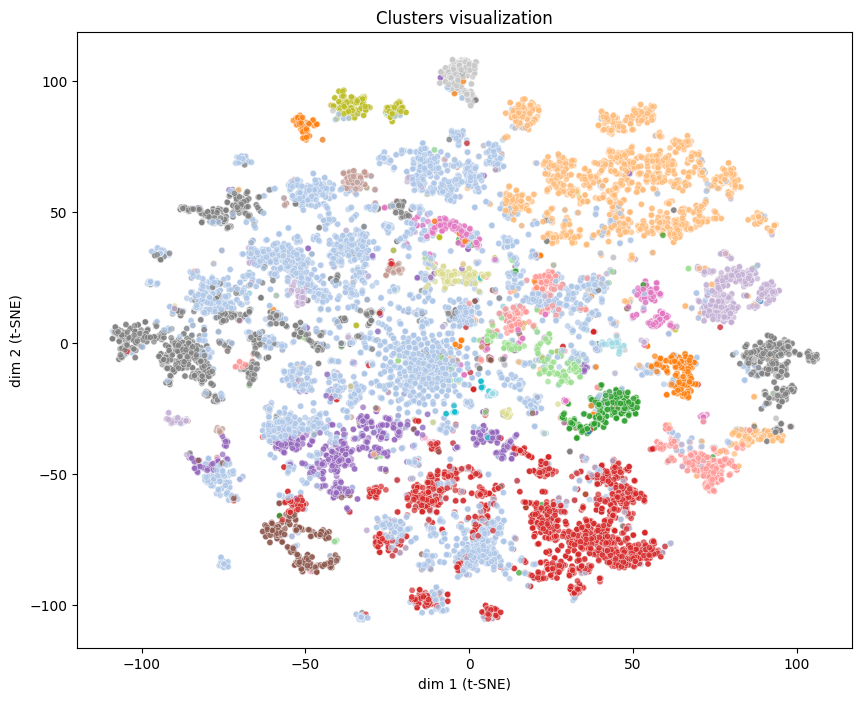

Saved figure to tsne_clusters.png and tsne_clusters.pdf


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_clusters(emd_cluster, year, sample_size=20000, out_prefix="tsne_clusters"):
    # Filter embeddings
    df = emd_cluster
    X = df.filter(like="dim_").values
    y = df["cluster"].values

    # Subsample if too large
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
        X = df.filter(like="dim_").values
        y = df["cluster"].values

    # Dimensionality reduction
    X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=X_2d[:,0], y=X_2d[:,1], hue=y,
        palette="tab20", s=20, alpha=0.7, legend=False
    )
    plt.title(f"Clusters visualization")
    plt.xlabel("dim 1 (t-SNE)")
    plt.ylabel("dim 2 (t-SNE)")

    # Save outputs (PNG for quick view, PDF for LaTeX)
    png_path = f"{out_prefix}.png"
    pdf_path = f"{out_prefix}.pdf"
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

    plt.show()
    print(f"Saved figure to {png_path} and {pdf_path}")
visualize_clusters(emd_cluster, 2024)


In [ ]:
perf = pd.read_csv("./202507_performance.csv")
cluster = pd.read_csv("./clusters_all.csv")
perf.head()

,permno,year,ret
0,10000,1985,0.000000
1,10000,1986,-0.826087
2,10000,1987,-0.575757
3,10001,1985,0.000000
4,10001,1986,0.217369


In [ ]:
cluster.head()

,firm,year,cluster
0,10001,1998,31
1,10001,1999,31
2,10001,2000,31
3,10001,2001,10
4,10001,2011,28


In [ ]:
merged = perf.merge(
    cluster.reset_index(),
    left_on=["permno", "year"],
    right_on=["firm", "year"],
    how="inner"
)

firm_perf_clusters = (
    merged.drop(columns=["permno", "index"])   # drop first
          .set_index(["firm", "year"])  # then set index
)

firm_perf_clusters.head()


ret  cluster
firm  year                   
10001 1998  0.124245       31
      1999 -0.066220       31
      2000  0.214725       31
      2001  0.229015       10
      2011  0.139163       28

In [ ]:
firm_perf_clusters.head()


ret  cluster
firm  year                   
10001 1998  0.124245       31
      1999 -0.066220       31
      2000  0.214725       31
      2001  0.229015       10
      2011  0.139163       28

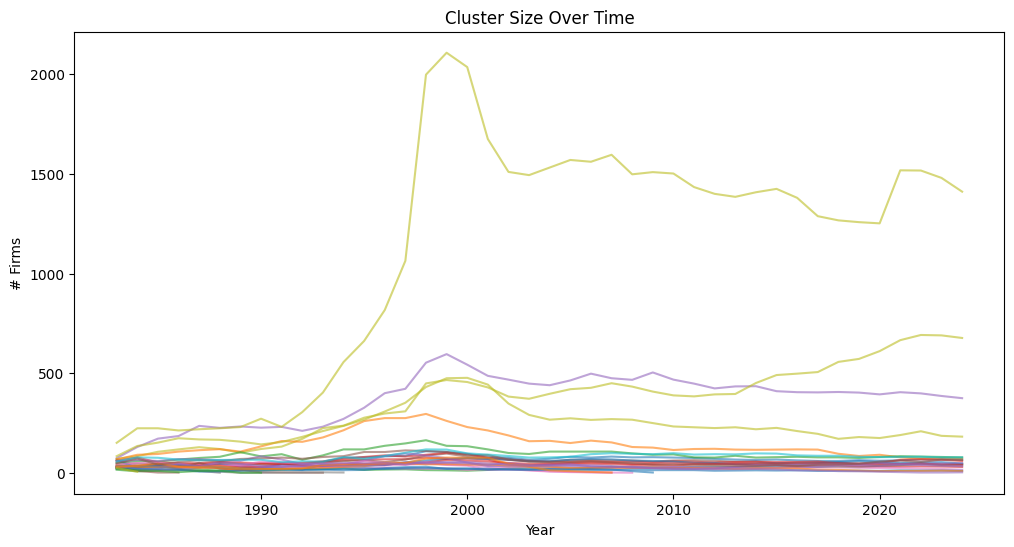

In [ ]:
import matplotlib.pyplot as plt

cluster_counts = firm_perf_clusters.groupby(["year", "cluster"]).size().reset_index(name="n_firms")

plt.figure(figsize=(12,6))
for c in cluster_counts["cluster"].unique():
    sub = cluster_counts[cluster_counts["cluster"] == c]
    plt.plot(sub["year"], sub["n_firms"], label=f"Cluster {c}", alpha=0.6)
plt.title("Cluster Size Over Time")
plt.xlabel("Year")
plt.ylabel("# Firms")
plt.savefig("cluster_size_all.png", dpi=300, bbox_inches="tight")
plt.show()



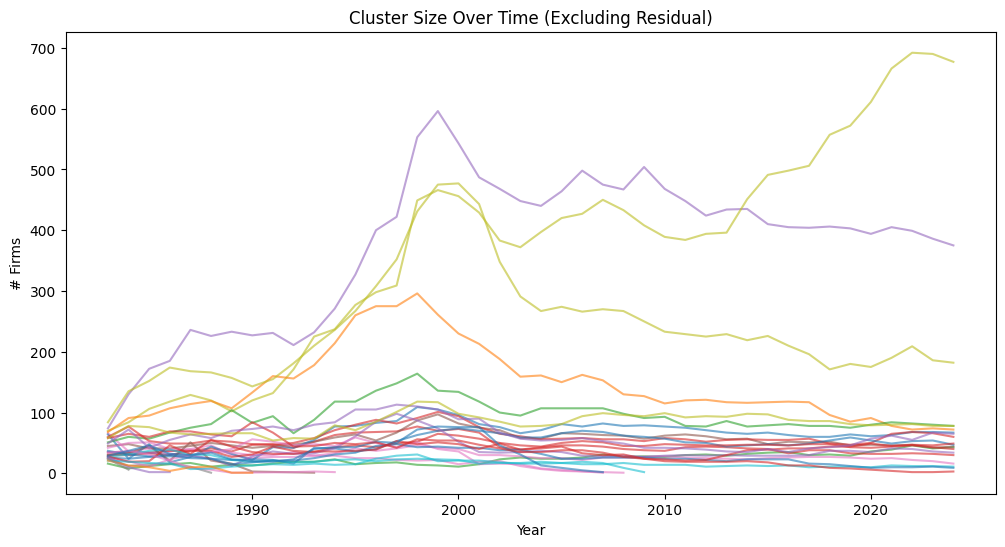

In [ ]:
# Identify residual cluster = biggest avg size
residual_cluster = cluster_counts.groupby("cluster")["n_firms"].mean().idxmax()

# Exclude residual cluster
cluster_counts_nores = cluster_counts[cluster_counts["cluster"] != residual_cluster]

plt.figure(figsize=(12,6))
for c in cluster_counts_nores["cluster"].unique():
    sub = cluster_counts_nores[cluster_counts_nores["cluster"] == c]
    plt.plot(sub["year"], sub["n_firms"], label=f"Cluster {c}", alpha=0.6)
plt.title("Cluster Size Over Time (Excluding Residual)")
plt.xlabel("Year")
plt.ylabel("# Firms")
plt.savefig("cluster_size_nores.png", dpi=300, bbox_inches="tight")
plt.show()

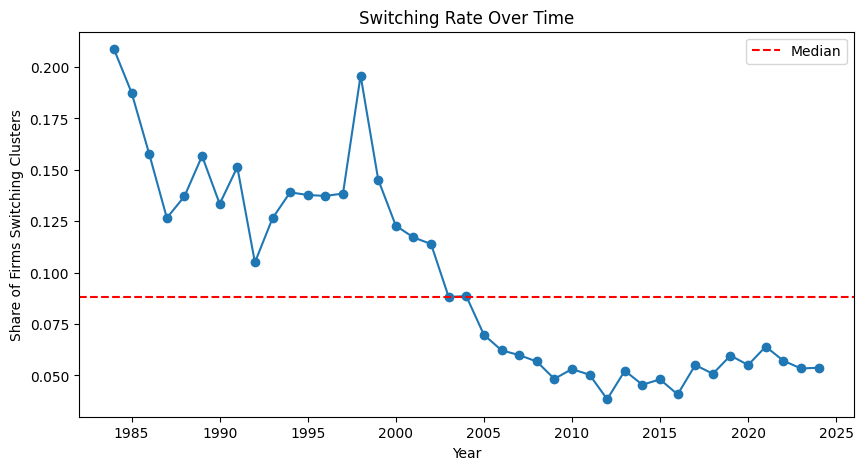

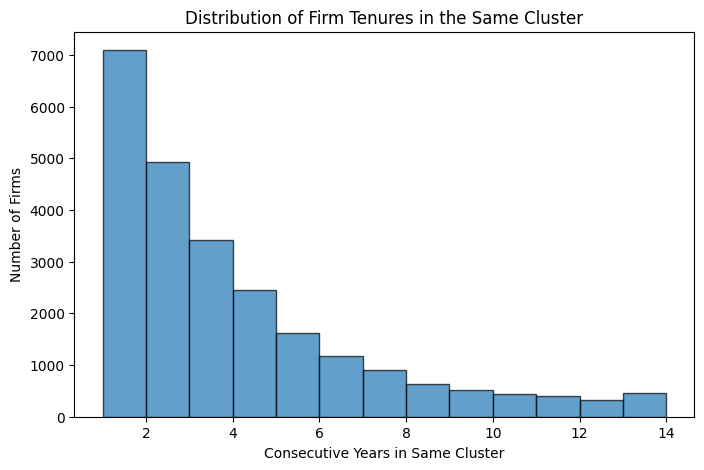

Median tenure: 3.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# If firm, year are in the index -> make them columns
df = firm_perf_clusters.reset_index().copy()

# Ensure sorting
df = df.sort_values(["firm", "year"])

# -------------------------
# 1) Switching Rate
# -------------------------
df["cluster_prev"] = df.groupby("firm")["cluster"].shift(1)
df["year_prev"] = df.groupby("firm")["year"].shift(1)

# Only compare consecutive years
df["is_consecutive"] = df["year"] - df["year_prev"] == 1
df["switched"] = (df["cluster"] != df["cluster_prev"]) & df["is_consecutive"]

# Compute switching rate per year
switching_rate = (
    df[df["is_consecutive"]]
    .groupby("year")["switched"]
    .mean()
    .reset_index(name="switch_rate")
)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(switching_rate["year"], switching_rate["switch_rate"], marker="o")
plt.axhline(switching_rate["switch_rate"].median(), color="red", linestyle="--", label="Median")
plt.title("Switching Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Share of Firms Switching Clusters")
plt.legend()
plt.savefig("switching_rate.png", dpi=300, bbox_inches="tight")
plt.show()


# -------------------------
# 2) Tenure Distribution
# -------------------------
def compute_tenures(cluster_series, year_series):
    """Compute consecutive run lengths of same cluster for one firm"""
    tenures = []
    prev_cluster = None
    prev_year = None
    length = 0
    for c, y in zip(cluster_series, year_series):
        if prev_cluster is None:  # first year
            length = 1
        elif (c == prev_cluster) and (y == prev_year + 1):
            length += 1
        else:
            tenures.append(length)
            length = 1
        prev_cluster, prev_year = c, y
    tenures.append(length)
    return tenures

# Collect all firms’ tenures
all_tenures = []
for _, g in df.groupby("firm"):
    all_tenures.extend(compute_tenures(g["cluster"].values, g["year"].values))

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(all_tenures, bins=range(1, 15), edgecolor="black", alpha=0.7)
plt.title("Distribution of Firm Tenures in the Same Cluster")
plt.xlabel("Consecutive Years in Same Cluster")
plt.ylabel("Number of Firms")
plt.savefig("tenure_hist.png", dpi=300, bbox_inches="tight")
plt.show()

print("Median tenure:", pd.Series(all_tenures).median())


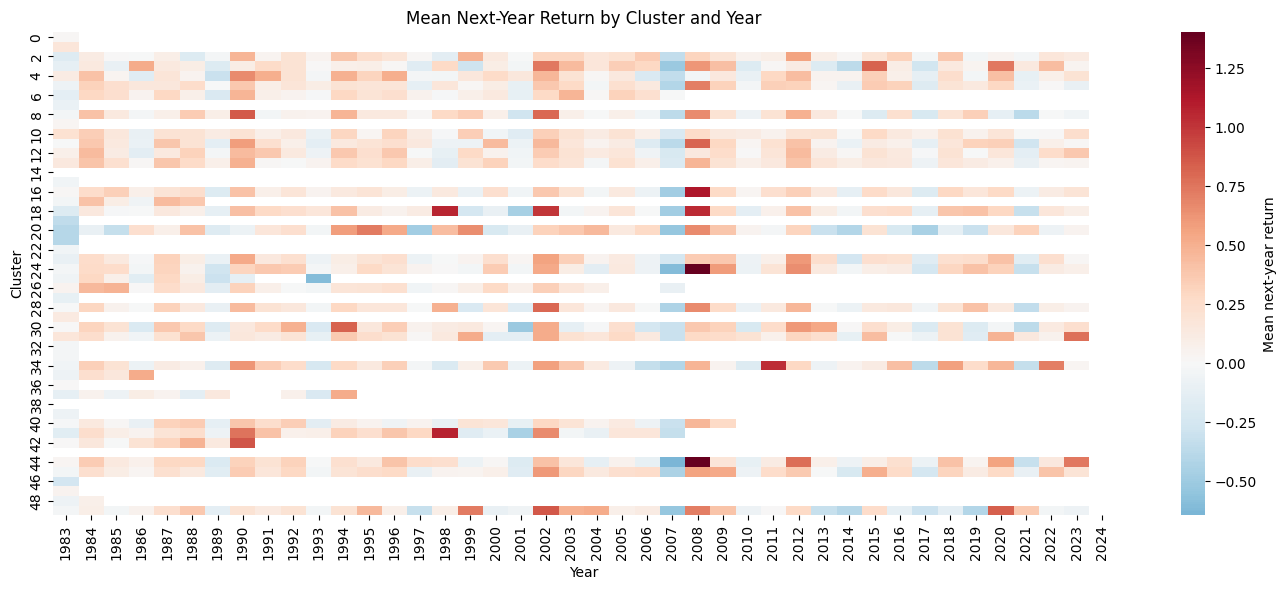

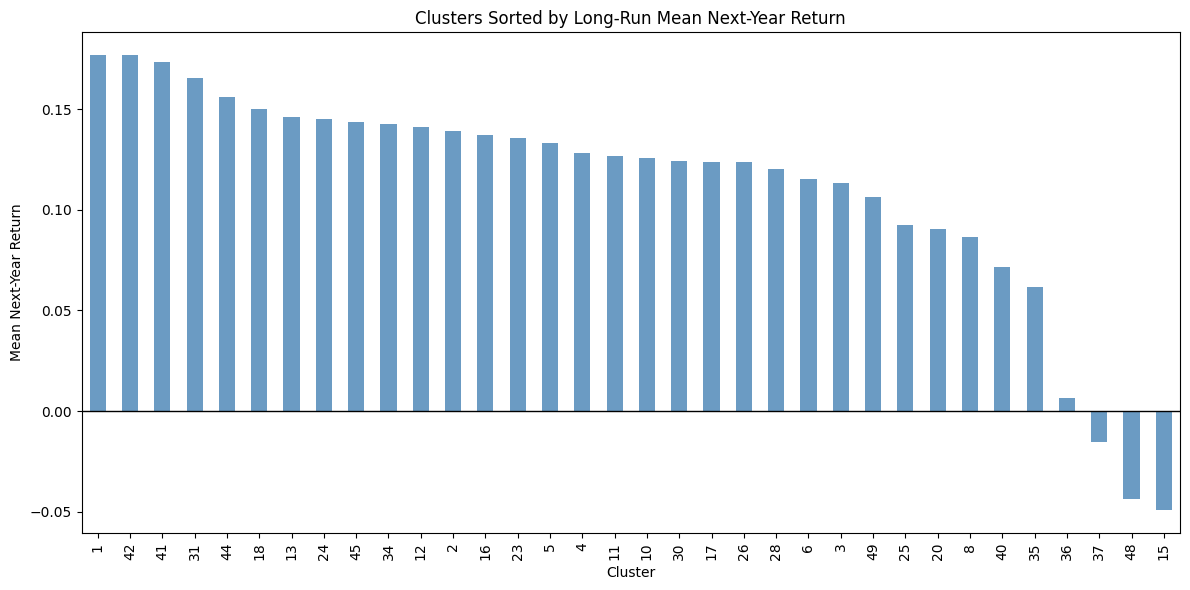

Top clusters:
              mean  count
cluster                 
1        0.176846      6
42       0.176753     62
41       0.173303    849
31       0.165259   1004
44       0.156054   1415

Bottom clusters:
              mean  count
cluster                 
35       0.061597     32
36       0.006318      6
37      -0.015386    128
48      -0.043536     30
15      -0.049286      8
Top 5 clusters:
              mean  count
cluster                 
1        0.176846      6
42       0.176753     62
41       0.173303    849
31       0.165259   1004
44       0.156054   1415

Bottom 5 clusters:
              mean  count
cluster                 
19      -0.355706      1
21      -0.400000      1
14            NaN      0
38            NaN      0
43            NaN      0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure firm, year are columns
df = firm_perf_clusters.reset_index().copy()

# -----------------------------
# 1) Compute next-year returns
# -----------------------------
# ret_{t+1} for each firm
df["ret_lead"] = df.groupby("firm")["ret"].shift(-1)

# -----------------------------
# 2) Heatmap of mean next-year return by (year, cluster)
# -----------------------------
heat = (
    df.groupby(["year", "cluster"])["ret_lead"]
    .mean()
    .unstack("cluster")
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat.T, cmap="RdBu_r", center=0,
    cbar_kws={"label": "Mean next-year return"}
)
plt.title("Mean Next-Year Return by Cluster and Year")
plt.xlabel("Year")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("heat_nextret.png", dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 3) Bar chart: long-run average next-year return per cluster
# -----------------------------
# Compute mean + count
cluster_perf = (
    df.groupby("cluster")["ret_lead"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=False)
)

# Keep only clusters with at least 5 valid observations
cluster_perf_filtered = cluster_perf[cluster_perf["count"] >= 5]

# Plot
plt.figure(figsize=(12,6))
cluster_perf_filtered["mean"].plot(kind="bar", color="steelblue", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Clusters Sorted by Long-Run Mean Next-Year Return")
plt.xlabel("Cluster")
plt.ylabel("Mean Next-Year Return")
plt.tight_layout()
plt.savefig("bar_nextret.png", dpi=300, bbox_inches="tight")
plt.show()

print("Top clusters:\n", cluster_perf_filtered.head())
print("\nBottom clusters:\n", cluster_perf_filtered.tail())

# Optionally print top/bottom clusters
print("Top 5 clusters:\n", cluster_perf.head())
print("\nBottom 5 clusters:\n", cluster_perf.tail())


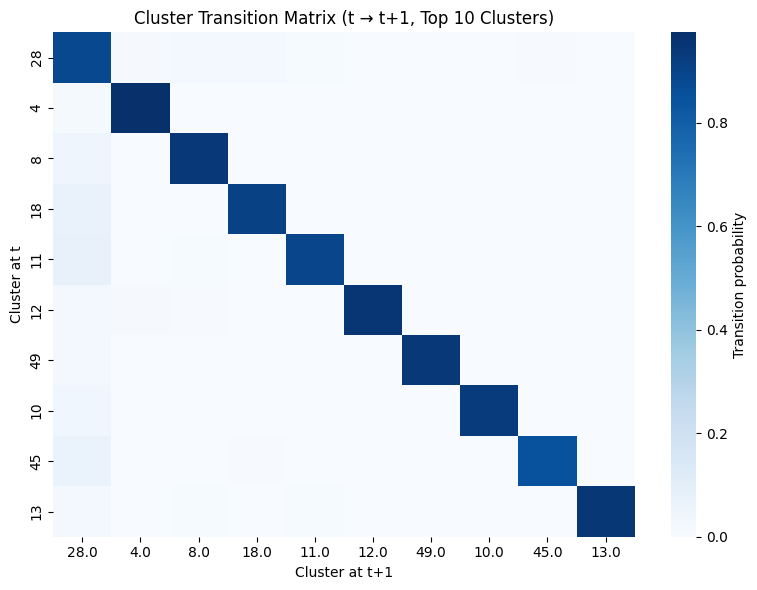

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure firm/year are columns
df = firm_perf_clusters.reset_index().copy()
df = df.sort_values(["firm", "year"])

# -------------------------
# 1) Build transitions
# -------------------------
df["cluster_next"] = df.groupby("firm")["cluster"].shift(-1)
df["year_next"] = df.groupby("firm")["year"].shift(-1)

# Keep only true year-to-year transitions
transitions = df[df["year_next"] == df["year"] + 1].dropna(subset=["cluster_next"])

# Build transition counts
T = pd.crosstab(transitions["cluster"], transitions["cluster_next"])

# Row-normalize → transition probabilities
T = T.div(T.sum(axis=1), axis=0).fillna(0)

# -------------------------
# 2) Focus on top clusters (optional, for readability)
# -------------------------
# Select top 10 clusters by average size
cluster_sizes = df.groupby("cluster").size()
top_clusters = cluster_sizes.sort_values(ascending=False).head(10).index
T_top = T.loc[top_clusters, top_clusters]

# -------------------------
# 3) Plot heatmap
# -------------------------
plt.figure(figsize=(8,6))
sns.heatmap(
    T_top, cmap="Blues", annot=False, cbar_kws={"label": "Transition probability"}
)
plt.title("Cluster Transition Matrix (t → t+1, Top 10 Clusters)")
plt.xlabel("Cluster at t+1")
plt.ylabel("Cluster at t")
plt.tight_layout()
plt.savefig("transition_matrix_top10.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd

transitions = (
    firm_perf_clusters.dropna()
    .groupby("firm")
    .apply(lambda g: pd.DataFrame({"from": g["cluster"], "to": g["cluster"].shift(-1)}))
    .dropna()
)
transition_matrix = pd.crosstab(transitions["from"], transitions["to"], normalize="index")


In [ ]:
# Count number of unique clusters per firm
switch_stats = (
    df.groupby("firm")["cluster"]
      .nunique()
      .reset_index(name="n_clusters")
      .sort_values("n_clusters", ascending=False)
)

# Firms that switched the most (top 10)
top_switchers = switch_stats.head(10)
print("Top switching firms:\n", top_switchers)

# Get their cluster trajectory
firm_id = top_switchers.iloc[0]["firm"]  # pick the top switcher
print(df[df["firm"] == firm_id][["year","cluster","ret"]])


Top switching firms:
        firm  n_clusters
4164  26382           7
5009  47002           7
4967  46295           7
4220  27334           7
8023  79689           7
4790  42569           6
5010  47028           6
4910  45137           6
9108  82599           6
4111  25487           6
       year  cluster       ret
34095  1983       20 -0.078543
34096  1984       49 -0.121377
34097  1985       49  0.076502
34098  1986       34 -0.236694
34099  1987       49  0.195651
34100  1988       34  0.703074
34101  1989       34  0.581502
34102  1990       34  0.006682
34103  1991       34  0.199444
34104  1992       34 -0.033028
34105  1993        2 -0.021307
34106  1994        2  0.076848
34107  1995       26  0.547721
34108  1996       26 -0.038853
34109  1997       26 -0.394821
34110  1998       26  0.157175
34111  1999       26  0.104192
34112  2000       26  0.154288
34113  2001        3  0.639511
34114  2002        3 -0.523648
34115  2003        3  1.166202
34116  2004        3  0.689982
3

# Case Study: MAG7 Firms

To validate our clustering method, we examine the membership of major technology firms (“MAG7”):  
**Microsoft (MSFT), Apple (AAPL), Alphabet (GOOG, GOOGL), Amazon (AMZN), Meta (META, FB), Tesla (TSLA), and Nvidia (NVDA).**

These firms are globally significant and provide a useful benchmark for checking whether our clusters capture intuitive industry structure.
## Mapping Firms to PERMNO Identifiers

We start by matching the stock tickers of the MAG7 to their corresponding CRSP `PERMNO` identifiers.  
This allows us to align them with our firm–year dataset and cluster assignments.
## Cluster Membership over Time

We merge the MAG7 firm identifiers with the cluster results.  
Each firm–year is now associated with a cluster label.  

This enables us to trace how each MAG7 company’s cluster assignment evolves across time.
## Group Summary

We summarize cluster membership by grouping firm–years of each MAG7 firm.  
This shows:
- The distribution of clusters each firm has belonged to.  
- The persistence or changes in cluster assignment over time.  

Such analysis highlights whether MAG7 companies consistently belong to similar clusters (e.g., “Big Tech”) or transition across different clusters.


In [ ]:
perrno_firms = pd.read_csv("./kjgrmqsegjdimivq.csv")
perrno_firms[perrno_firms["PERMNO"] == 26382]

,PERMNO,HCOMNAM,HTSYMBOL,HNAICS,HSICCD,BEGDAT,ENDDAT
15040,26382,MASSEY ENERGY CO,MEE,212111.0,1221,1957-10-28,2011-06-01


In [ ]:
# List of tickers for MAG7
mag7_tickers = ["MSFT", "AAPL", "GOOG", "GOOGL", "AMZN", "META", "FB", "TSLA", "NVDA"]

# Find their PERMNOs
mag7_firms = perrno_firms[perrno_firms["HTSYMBOL"].isin(mag7_tickers)]
print("MAG7 mapping:\n", mag7_firms[["PERMNO","HCOMNAM","HTSYMBOL","BEGDAT","ENDDAT"]])

# Merge with cluster assignments
df = firm_perf_clusters.reset_index()  # firm/year/cluster
mag7_clusters = df.merge(mag7_firms[["PERMNO","HCOMNAM","HTSYMBOL"]],
                         left_on="firm", right_on="PERMNO", how="inner")

# See their cluster membership
print(mag7_clusters.sort_values(["HCOMNAM","year"]).head(20))

# Group summary: which clusters they belong to
mag7_summary = (
    mag7_clusters.groupby(["HCOMNAM","cluster"])
    .size()
    .reset_index(name="n_years")
    .sort_values(["HCOMNAM","n_years"], ascending=[True,False])
)
print(mag7_summary)


MAG7 mapping:
        PERMNO                      HCOMNAM HTSYMBOL      BEGDAT      ENDDAT
107     10107               MICROSOFT CORP     MSFT  1986-03-13  2024-12-31
3301    13407           META PLATFORMS INC     META  2012-05-18  2024-12-31
4333    14542                 ALPHABET INC     GOOG  2014-04-03  2024-12-31
4384    14593                    APPLE INC     AAPL  1980-12-12  2024-12-31
24895   76947    METATEC INTERNATIONAL INC     META  1991-06-05  2002-04-25
31400   84788               AMAZON COM INC     AMZN  1997-05-15  2024-12-31
32863   86580                  NVIDIA CORP     NVDA  1999-01-22  2024-12-31
33368   87208  F B R ASSET INVESTMENT CORP       FB  1999-09-29  2003-03-28
35851   90319                 ALPHABET INC    GOOGL  2004-08-19  2024-12-31
38871   93436                    TESLA INC     TSLA  2010-06-29  2024-12-31
      firm  year       ret  cluster  PERMNO       HCOMNAM HTSYMBOL
163  90319  2004  0.883267       28   90319  ALPHABET INC    GOOGL
164  90319  200

# Cluster-Level Financial Statistics

Once clusters are assigned, we evaluate their financial performance over time.  
We aggregate firm returns at the **cluster–year** level to study whether clusters capture systematic differences in outcomes.
## Aggregation of Returns

For each cluster in each year, we compute descriptive statistics of returns:  
- Mean, standard deviation, and median  
- Skewness and kurtosis (distribution shape)  
- Minimum and maximum  
- 25th and 75th percentiles  
- Absolute mean return (magnitude of performance regardless of sign)  

This provides a comprehensive view of return behavior across clusters.
## Coefficient of Variation

We calculate the coefficient of variation (CV), defined as:  

$$
CV = \frac{\text{std return}}{\text{mean return}}
$$

This measures relative risk compared to average performance.  
Clusters with high CV exhibit greater volatility relative to their mean.
## Lagged Features

To enable predictive modeling, we add lagged cluster statistics:  
- Previous year’s mean, std, median, skew, and kurtosis of returns.  

These lagged variables allow us to test whether past cluster performance predicts future outcomes.
## Target Variable (Next-Year Return)

As an optional step, we define **target_ret_next** as the cluster’s mean return in the following year.  
This transforms the dataset into a supervised learning setting, suitable for evaluating whether clusters have predictive power for future returns.


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis

# reset index so we can groupby easily
df = merged.reset_index()

# aggregate at cluster-year level
cluster_stats = (
    df.groupby(["cluster", "year"], as_index=False)
      .agg(
          mean_ret=("ret", "mean"),
          std_ret=("ret", "std"),
          median_ret=("ret", "median"),
          n_firms=("firm", "nunique"),
          skew_ret=("ret", lambda x: skew(x, nan_policy="omit")),
          kurt_ret=("ret", lambda x: kurtosis(x, nan_policy="omit")),
          min_ret=("ret", "min"),
          max_ret=("ret", "max"),
          q25_ret=("ret", lambda x: np.nanpercentile(x, 25)),
          q75_ret=("ret", lambda x: np.nanpercentile(x, 75)),
          abs_mean_ret=("ret", lambda x: np.nanmean(np.abs(x))),
      )
)

# coefficient of variation
cluster_stats["cv_ret"] = cluster_stats["std_ret"] / cluster_stats["mean_ret"].replace(0, np.nan)

# add lagged features by cluster
cluster_stats = cluster_stats.sort_values(["cluster", "year"])
for col in ["mean_ret", "std_ret", "median_ret", "skew_ret", "kurt_ret"]:
    cluster_stats[f"{col}_lag1"] = cluster_stats.groupby("cluster")[col].shift(1)

# optional: target (next-year return)
cluster_stats["target_ret_next"] = cluster_stats.groupby("cluster")["mean_ret"].shift(-1)

# drop missing targets if you want supervised dataset
cluster_stats = cluster_stats.dropna(subset=["target_ret_next"])
cluster_stats

,cluster,year,mean_ret,std_ret,median_ret,n_firms,skew_ret,kurt_ret,min_ret,max_ret,q25_ret,q75_ret,abs_mean_ret,cv_ret,mean_ret_lag1,std_ret_lag1,median_ret_lag1,skew_ret_lag1,kurt_ret_lag1,target_ret_next
2,2,1983,0.245184,0.414987,0.228708,16,0.034137,-0.285933,-0.580246,1.052696,0.024170,0.532850,0.380746,1.692554,NaN,NaN,NaN,NaN,NaN,-0.231759
3,2,1984,-0.231759,0.270180,-0.249423,8,-0.265469,-1.156532,-0.675676,0.085472,-0.392910,0.024592,0.265894,-1.165779,0.245184,0.414987,0.228708,0.034137,-0.285933,0.297565
4,2,1985,0.297565,0.322663,0.378437,12,-0.002638,-1.032877,-0.159091,0.861331,0.048933,0.486335,0.356142,1.084342,-0.231759,0.270180,-0.249423,-0.265469,-1.156532,0.009481
5,2,1986,0.009481,0.268356,0.029152,15,0.047592,-1.081735,-0.406161,0.491312,-0.236256,0.190726,0.223107,28.304220,0.297565,0.322663,0.378437,-0.002638,-1.032877,0.001036
6,2,1987,0.001036,0.420873,-0.159611,17,1.349683,0.747465,-0.559055,0.972970,-0.210890,0.014711,0.298863,406.153754,0.009481,0.268356,0.029152,0.047592,-1.081735,0.041637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,49,2019,-0.116487,0.406841,-0.135716,81,0.301757,-0.329342,-0.847311,0.847426,-0.432241,0.129560,0.340212,-3.492583,-0.316927,0.297965,-0.312858,0.141747,-0.186197,-0.275835
1036,49,2020,-0.275835,0.645205,-0.436760,79,2.970973,10.595070,-0.799379,3.043908,-0.638668,-0.222184,0.545605,-2.339097,-0.116487,0.406841,-0.135716,0.301757,-0.329342,0.764388
1037,49,2021,0.764388,0.730854,0.592572,80,0.383946,-0.959147,-0.505622,2.016347,0.199781,1.357450,0.821028,0.956130,-0.275835,0.645205,-0.436760,2.970973,10.595070,0.306536
1038,49,2022,0.306536,0.450849,0.396551,81,-0.703703,-0.059208,-0.951936,0.946307,0.017330,0.628105,0.462903,1.470789,0.764388,0.730854,0.592572,0.383946,-0.959147,-0.069962


In [ ]:
df

,level_0,permno,year,ret,index,firm,cluster
0,0,10001,1998,0.124245,0,10001,31
1,1,10001,1999,-0.066220,1,10001,31
2,2,10001,2000,0.214725,2,10001,31
3,3,10001,2001,0.229015,3,10001,10
4,4,10001,2011,0.139163,4,10001,28
...,...,...,...,...,...,...,...
129980,129980,93436,2020,3.643981,129980,93436,24
129981,129981,93436,2021,0.497554,129981,93436,24
129982,129982,93436,2022,-0.650315,129982,93436,24
129983,129983,93436,2023,1.017211,129983,93436,24


In [ ]:
cluster_stats.columns

Index(['cluster', 'year', 'mean_ret', 'std_ret', 'median_ret', 'n_firms',
       'skew_ret', 'kurt_ret', 'min_ret', 'max_ret', 'q25_ret', 'q75_ret',
       'abs_mean_ret', 'cv_ret', 'mean_ret_lag1', 'std_ret_lag1',
       'median_ret_lag1', 'skew_ret_lag1', 'kurt_ret_lag1', 'target_ret_next'],
      dtype='object')

# Predictive Modeling with XGBoost

Beyond descriptive analysis, we test whether cluster-level features have predictive power for future returns.  
We frame this as a supervised learning problem, where the target variable is the cluster’s mean return in the following year (`target_ret_next`).
## Data Preparation

- We sort the dataset by year to maintain chronological order.  
- The most recent years are held out as a **test set**, while earlier years form the training set.  
- Features consist of cluster-level statistics (mean, std, skew, kurtosis, lagged values, etc.), and the target is next-year return.
## Model: XGBoost Regressor

We apply the XGBoost regression algorithm, which is well-suited for structured/tabular data.  
Hyperparameters include:  
- `n_estimators=200` (number of boosting rounds)  
- `max_depth=4` (tree depth)  
- `learning_rate=0.05`  
- `subsample=0.8` and `colsample_bytree=0.8` (regularization through subsampling)  

These settings balance predictive accuracy and generalization.
## Training and Evaluation

- The model is trained on the training set and evaluated on the test set.  
- Predictions correspond to estimated cluster-level mean returns in the following year.  
- Performance is evaluated using metrics such as **mean squared error (MSE)** and correlation with actual outcomes.  

This analysis assesses whether clusters contain information useful for forecasting future performance.


In [ ]:
clean_no28 = clean[clean["cluster"] != 28].copy()

print("Original dataset:", clean["cluster"].nunique(), "clusters")
print("Without cluster 28:", clean_no28["cluster"].nunique(), "clusters")


Original dataset: 30 clusters
Without cluster 28: 29 clusters


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

def run_xgb(data, n_test_years=4):
    # Sort by year
    data = data.sort_values("year")

    # Define last years as test set
    last_years = data["year"].unique()[-n_test_years:]

    train = data[~data["year"].isin(last_years)]
    test  = data[data["year"].isin(last_years)]

    X_train = train.drop(columns=["target_ret_next"])
    y_train = train["target_ret_next"]
    X_test  = test.drop(columns=["target_ret_next"])
    y_test  = test["target_ret_next"]

    print(f"Train years: {train['year'].min()}–{train['year'].max()}, size={len(train)}")
    print(f"Test years: {list(last_years)}, size={len(test)}")

    # --- XGBoost ---
    model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = model.score(X_test, y_test)

    return rmse, r2

# --- Run with all clusters ---
print("=== With all clusters (clean) ===")
rmse_all, r2_all = run_xgb(clean)

# --- Run excluding cluster 28 ---
clean_no28 = clean[clean["cluster"] != 28].copy()
print("\n=== Without cluster 28 (clean_no28) ===")
rmse_no28, r2_no28 = run_xgb(clean_no28)

# --- Summary ---
print("\n📊 Comparison:")
print(f"With cluster 28   -> RMSE={rmse_all:.4f}, R²={r2_all:.3f}")
print(f"Without cluster 28-> RMSE={rmse_no28:.4f}, R²={r2_no28:.3f}")


=== With all clusters (clean) ===
Train years: 1984–2019, size=873
Test years: [2020, 2021, 2022, 2023], size=84

=== Without cluster 28 (clean_no28) ===
Train years: 1984–2019, size=837
Test years: [2020, 2021, 2022, 2023], size=80

📊 Comparison:
With cluster 28   -> RMSE=0.2867, R²=-0.368
Without cluster 28-> RMSE=0.2935, R²=-0.426


# Time-Series Forecasting with ARIMA

In addition to machine learning methods, we apply **ARIMA models** to forecast cluster-level returns.  
ARIMA (AutoRegressive Integrated Moving Average) is a standard statistical approach for time-series forecasting, capturing both trend and autocorrelation.
## Methodology

1. **Per-Cluster Forecasting**  
   - We run ARIMA models separately for each cluster.  
   - This allows us to capture idiosyncratic return dynamics within clusters.

2. **Train/Test Split**  
   - As with XGBoost, the most recent years are held out as the test period.  
   - Only clusters with sufficient historical data extending into the test window are included.

3. **Model Specification**  
   - We use an ARIMA(1,1,1) specification, a common baseline for financial returns.  
   - Forecasts are generated for the length of the test period.
## Evaluation

Forecast accuracy is evaluated using:  
- **Root Mean Squared Error (RMSE):** measures prediction error magnitude.  
- **R² score:** measures how much variance in future returns is explained by the model.

These metrics are aggregated across clusters to evaluate overall forecasting performance.
## Comparison: With vs. Without Specific Clusters

We also run ARIMA models under different dataset definitions:  
- **Full dataset (all clusters included)**  
- **Dataset excluding cluster 28**  

This comparison allows us to test whether specific clusters disproportionately affect forecasting accuracy.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

def run_arima(data, n_test_years=4):
    data = data.sort_values(["cluster","year"])

    preds, true = [], []
    last_years = data["year"].unique()[-n_test_years:]

    for cluster_id, subdf in data.groupby("cluster"):
        subdf = subdf.set_index("year").sort_index()

        # Only use clusters that extend into test period
        if subdf.index.max() < min(last_years):
            continue

        train_sub = subdf.loc[subdf.index < min(last_years), "mean_ret"]
        test_sub  = subdf.loc[subdf.index.isin(last_years), "mean_ret"]

        if len(train_sub) < 5 or len(test_sub) == 0:
            continue

        try:
            model = ARIMA(train_sub, order=(1,1,1), enforce_invertibility=False)
            fit = model.fit()
            pred = fit.forecast(steps=len(test_sub))

            preds.extend(pred)
            true.extend(test_sub.values)
        except Exception as e:
            print(f"Cluster {cluster_id} failed: {e}")
            continue

    rmse = np.sqrt(mean_squared_error(true, preds))
    r2   = r2_score(true, preds)
    return rmse, r2

# --- Run ARIMA on both datasets ---
print("=== ARIMA with all clusters (clean) ===")
rmse_arima_all, r2_arima_all = run_arima(clean)

print("\n=== ARIMA without cluster 28 (clean_no28) ===")
rmse_arima_no28, r2_arima_no28 = run_arima(clean_no28)

print("\n📊 ARIMA Comparison:")
print(f"With cluster 28   -> RMSE={rmse_arima_all:.4f}, R²={r2_arima_all:.3f}")
print(f"Without cluster 28-> RMSE={rmse_arima_no28:.4f}, R²={r2_arima_no28:.3f}")


=== ARIMA with all clusters (clean) ===


/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No s


=== ARIMA without cluster 28 (clean_no28) ===


/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be


📊 ARIMA Comparison:
With cluster 28   -> RMSE=0.2579, R²=-0.078
Without cluster 28-> RMSE=0.2562, R²=-0.077


/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Multivariate Forecasting with VAR

To capture interdependencies between clusters, we apply a **Vector AutoRegression (VAR)** model.  
Unlike ARIMA, which models each cluster separately, VAR models all clusters jointly, allowing cluster returns to influence each other.
## Methodology

1. **Pivot to Year × Cluster Matrix**  
   - We reshape the data into a matrix of cluster mean returns by year.  
   - Each column is a cluster, and each row is a year.

2. **Train/Test Split**  
   - As before, the last few years are held out for testing.  
   - Training is performed on earlier years.
## Model Fitting

- We fit a VAR model with one lag (`lags=1`), meaning each year’s cluster returns depend on the previous year’s values.  
- This setup captures cross-cluster dynamics, where the performance of one cluster may help forecast another.
## Forecasting and Evaluation

- The trained VAR model produces forecasts for the test years.  
- We compare predictions with actual returns using:  
  - **Root Mean Squared Error (RMSE)**  
  - **R² score**  

These metrics assess both error magnitude and explained variance across clusters.
## Robustness Check: Excluding Cluster 28

As with ARIMA, we compare results with and without **Cluster 28**.  
This evaluates whether specific clusters drive overall forecasting accuracy.


In [ ]:
from statsmodels.tsa.api import VAR

def run_var(data, n_test_years=4, lags=1):
    # Pivot into year × cluster matrix of mean returns
    pivot = data.pivot_table(index="year", columns="cluster", values="mean_ret")
    pivot = pivot.sort_index().dropna(axis=1, how="any")  # drop clusters missing years

    # Train/test split
    last_years = pivot.index[-n_test_years:]
    train, test = pivot.loc[pivot.index.difference(last_years)], pivot.loc[last_years]

    # Fit VAR
    model = VAR(train)
    fit = model.fit(lags)

    # Forecast
    forecast = fit.forecast(train.values, steps=len(test))
    forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)

    # Align shapes
    true = test.values.flatten()
    pred = forecast_df.values.flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)

    return rmse, r2

# --- Run VAR for both datasets ---
print("=== VAR with all clusters (clean) ===")
rmse_var_all, r2_var_all = run_var(clean)

print("\n=== VAR without cluster 28 (clean_no28) ===")
rmse_var_no28, r2_var_no28 = run_var(clean_no28)

print("\n📊 VAR Comparison:")
print(f"With cluster 28   -> RMSE={rmse_var_all:.4f}, R²={r2_var_all:.3f}")
print(f"Without cluster 28-> RMSE={rmse_var_no28:.4f}, R²={r2_var_no28:.3f}")


=== VAR with all clusters (clean) ===

=== VAR without cluster 28 (clean_no28) ===

📊 VAR Comparison:
With cluster 28   -> RMSE=0.3729, R²=-1.255
Without cluster 28-> RMSE=0.3528, R²=-1.042


/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yonataba/rapids_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


# Cluster Characteristics

After forming clusters, we analyze their structural properties and dynamics.  
This provides insights into stability, variability, and firm mobility across clusters.
## 1. Cluster Sizes

We compute the number of unique firms in each cluster.  
Larger clusters may capture broad industry groups, while smaller clusters may reflect niche or specialized firm segments.
## 2. Never-Switchers Proportion

For each firm, we count how many different clusters it belongs to across years.  
- Firms that always remain in the same cluster are classified as **never-switchers**.  
- We calculate the share of never-switchers within each cluster.  

A high proportion of never-switchers indicates strong cluster stability.
## 3. Heterogeneity of Returns

We compute the variance of returns within each cluster.  
Clusters with higher variance are more heterogeneous, containing firms with diverse performance patterns.  
Low-variance clusters suggest more homogeneous financial behavior.
## 4. Mobility Between Clusters

We track firm mobility by comparing cluster assignments across consecutive years.  
This identifies firms that transition between clusters and highlights periods of structural change in the network.


In [ ]:
import pandas as pd

df = firm_perf_clusters.reset_index().copy()

# --------------------------------------------------
# 1) Cluster sizes
# --------------------------------------------------
cluster_sizes = df.groupby("cluster")["firm"].nunique().reset_index(name="n_firms")
cluster_sizes["rank_size"] = cluster_sizes["n_firms"].rank(ascending=False)
print("Top clusters by size:\n", cluster_sizes.sort_values("n_firms", ascending=False).head(10))

# --------------------------------------------------
# 2) Never-switchers proportion
# --------------------------------------------------
# compute for each firm how many unique clusters
firm_switches = df.groupby("firm")["cluster"].nunique().reset_index(name="n_clusters")
never_switchers = firm_switches[firm_switches["n_clusters"] == 1]["firm"]

never_switch_counts = (
    df[df["firm"].isin(never_switchers)]
    .groupby("cluster")["firm"].nunique()
    .reset_index(name="n_never_switch")
)

cluster_summary = cluster_sizes.merge(never_switch_counts, on="cluster", how="left").fillna(0)
cluster_summary["share_never_switch"] = cluster_summary["n_never_switch"] / cluster_summary["n_firms"]
print(cluster_summary.sort_values("share_never_switch", ascending=False).head(10))

# --------------------------------------------------
# 3) Heterogeneity of returns
# --------------------------------------------------
ret_var = df.groupby("cluster")["ret"].var().reset_index(name="var_ret")
cluster_summary = cluster_summary.merge(ret_var, on="cluster", how="left")

# --------------------------------------------------
# 4) Mobility out of cluster
# --------------------------------------------------
df = df.sort_values(["firm","year"])
df["cluster_next"] = df.groupby("firm")["cluster"].shift(-1)
df["year_next"] = df.groupby("firm")["year"].shift(-1)
transitions = df[df["year_next"] == df["year"]+1]

# probability of leaving each cluster
leave_rate = (
    transitions
    .assign(left=lambda x: x["cluster"] != x["cluster_next"])
    .groupby("cluster")["left"].mean()
    .reset_index(name="leave_prob")
)

cluster_summary = cluster_summary.merge(leave_rate, on="cluster", how="left")

# --------------------------------------------------
# Final summary
# --------------------------------------------------
print(cluster_summary.sort_values("n_firms", ascending=False).head(10))


Top clusters by size:
     cluster  n_firms  rank_size
28       28     8530        1.0
8         8     2244        2.0
4         4     1971        3.0
18       18     1538        4.0
11       11      888        5.0
49       49      548        6.0
12       12      487        7.0
45       45      427        8.0
13       13      349        9.0
44       44      284       10.0
    cluster  n_firms  rank_size  n_never_switch  share_never_switch
38       38        1       43.0             1.0            1.000000
14       14        1       43.0             1.0            1.000000
43       43        1       43.0             1.0            1.000000
4         4     1971        3.0          1180.0            0.598681
12       12      487        7.0           248.0            0.509240
49       49      548        6.0           265.0            0.483577
8         8     2244        2.0          1069.0            0.476381
28       28     8530        1.0          3856.0            0.452052
20       20  

# Case Studies: Amazon and Tesla

To further validate cluster assignments, we analyze whether firms cluster with their known industry peers.
## Amazon and Retail Peers

We identify major retail/consumer companies as Amazon’s natural comparison group (e.g., Walmart, Target, Costco, Home Depot).  
We then check Amazon’s cluster assignments over time and compare them with these retail peers.

This allows us to test whether Amazon is consistently grouped with traditional retail firms or whether it diverges into other clusters.
## Tesla and Auto Peers

Similarly, we track Tesla alongside major automotive firms (e.g., Ford, GM, Toyota, Honda, Stellantis).  
We evaluate whether Tesla is grouped within the automotive cluster or whether it shifts into other clusters (e.g., technology-related groups).

This provides insight into whether clustering captures Tesla’s hybrid identity as both an auto manufacturer and a technology innovator.
## Peer Group Summaries

For each firm, we summarize:  
- The clusters they belong to  
- The number of years spent in each cluster  

Comparing Amazon vs. retail peers and Tesla vs. auto peers helps assess whether our clustering method recovers economically intuitive groupings.


In [ ]:
# --- Known peers for Amazon (retail/consumer)
retail_tickers = ["WMT", "TGT", "COST", "HD", "KR", "BBY"]

# --- Known peers for Tesla (auto)
auto_tickers = ["F", "GM", "TM", "HMC", "STLA", "RIVN"]

# Get PERMNOs for these
retail_firms = perrno_firms[perrno_firms["HTSYMBOL"].isin(retail_tickers)]
auto_firms   = perrno_firms[perrno_firms["HTSYMBOL"].isin(auto_tickers)]

# Merge with cluster assignments
df = firm_perf_clusters.reset_index()

retail_clusters = df.merge(retail_firms[["PERMNO","HCOMNAM","HTSYMBOL"]],
                           left_on="firm", right_on="PERMNO", how="inner")

auto_clusters = df.merge(auto_firms[["PERMNO","HCOMNAM","HTSYMBOL"]],
                         left_on="firm", right_on="PERMNO", how="inner")

# Summaries
retail_summary = (
    retail_clusters.groupby(["HCOMNAM","cluster"])
    .size().reset_index(name="n_years")
    .sort_values(["HCOMNAM","n_years"], ascending=[True,False])
)

auto_summary = (
    auto_clusters.groupby(["HCOMNAM","cluster"])
    .size().reset_index(name="n_years")
    .sort_values(["HCOMNAM","n_years"], ascending=[True,False])
)

print("Amazon vs Retail Peers:\n", retail_summary.head(20))
print("\nTesla vs Auto Peers:\n", auto_summary.head(20))


Amazon vs Retail Peers:
                      HCOMNAM  cluster  n_years
0       BEST BUY COMPANY INC       11       33
1       BEST BUY COMPANY INC       28        2
2  COSTCO WHOLESALE CORP NEW       11       35
3  COSTCO WHOLESALE CORP NEW       28        1
4             HOME DEPOT INC       11       40
5                  KROGER CO       11       37
6                  KROGER CO       13        5
7                TARGET CORP       11       42
8                WALMART INC       11       42

Tesla vs Auto Peers:
                  HCOMNAM  cluster  n_years
0      FORD MOTOR CO DEL       24       42
1      GENERAL MOTORS CO       24       15
2    GENERAL MOTORS CORP       24       27
3  RIVIAN AUTOMOTIVE INC       24        4
